# Test the sample and distributional accuracy of the GNN-based probabilistic models

In [1]:
import numpy as np
import torch
from torchvision import transforms
import numpy as np
import tqdm

import dgn4cfd as dgn 

In [2]:
device = torch.device('cuda:0')

Settings:

In [3]:
DATASET = dgn.datasets.DatasetUrl.uvpAroundEllipseInDist
"""
Available test datasets:
    - DatasetUrl.uvpAroundEllipseInDist
    - DatasetUrl.uvpAroundEllipseLowRe
    - DatasetUrl.uvpAroundEllipseHighRe
    - DatasetUrl.uvpAroundEllipseThin
    - DatasetUrl.uvpAroundEllipseThick
"""
TIME_DATASET = dgn.datasets.DatasetUrl.TimeEllipseInDist # This dataset contains the length of each simulation in DATASET. This lenght is a multiple of the vortex-shedding period.
NUM_DENOISING_STEPS = 50
SIM_IDX = 25

Load the models:
- Diffusion Graph Net (DGN)
- Latent Diffusion Graph Net (LDGN)
- Vanilla Graph Net
- Bayesian Graph Net
- Gaussian Mixure Graph Net
- Variational Graph Autoencoder (VGAE)

In [4]:
# Diffusion Graph Net
DGN = dgn.nn.DiffusionGraphNet(
    checkpoint = "./checkpoints/dgn-nt10.chk",
    device     = device,
)

# Latent Diffusion Graph Net
LDGN = dgn.nn.LatentDiffusionGraphNet(
    autoencoder_checkpoint = "./checkpoints/ae-nt10.chk",
    checkpoint             = "./checkpoints/ldgn-nt10.chk",
    device                 = device,
)

# Vanilla Graph Net
VanillaGN = dgn.nn.VanillaGnn(
    checkpoint = "./checkpoints/vanilla-nt10.chk",
    device     = device,
) 

# Gassian Mixure Graph Net
GaussianMixGN = dgn.nn.GaussianMixtureGnn(
    checkpoint = "./checkpoints/gaussian-nt10.chk",
    device     = device,
)

# Variational Graph Autoencoder
VGAE = dgn.nn.VGAE(
    checkpoint = "./checkpoints/vgae-nt10.chk",
    device     = device,
)

Load a dataset

In [5]:
transform = transforms.Compose([
    dgn.transforms.ConnectKNN(6),
    dgn.transforms.ScaleEdgeAttr(0.15),
    dgn.transforms.ScaleNs({'u': (-1.8,1.8), 'v': (-1.8,1.8), 'p': (-3, 3), 'Re': (500,1000)}, format='uvp'),
    dgn.transforms.AddDirichletMask(3, [0,1], dirichlet_boundary_id=[2, 4]),
    dgn.transforms.MeshCoarsening(
        num_scales      =  5,
        rel_pos_scaling = [0.15, 0.3, 0.6, 1.2, 2.4],
        scalar_rel_pos  = True, 
    ),
])
dataset = dgn.datasets.uvpAroundEllipse(
    path          = dgn.datasets.DatasetDownloader(DATASET).file_path,
    T             = 101,
    transform     = transform,
)
print('Number of samples:', len(dataset))

# Load the length of each simulation to compute statistics
T = dgn.datasets.DatasetDownloader(TIME_DATASET).numpy()

Dataset already exists.
Number of samples: 50
Dataset already exists.


## Sample Inference

R2: 0.9801 at t=55


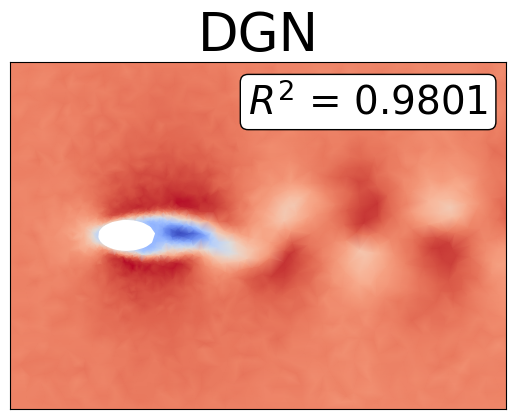

R2: 0.9925 at t=64


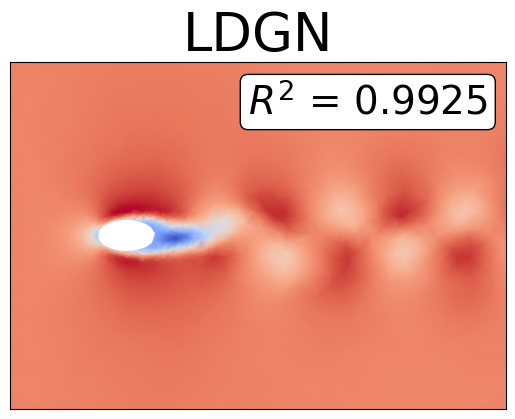

R2: 0.9747 at t=74


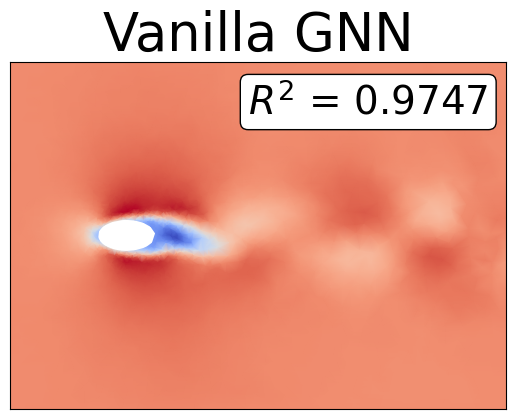

R2: 0.9667 at t=10


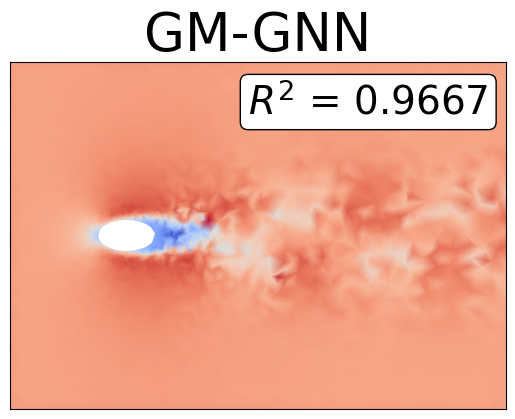

R2: 0.9723 at t=45


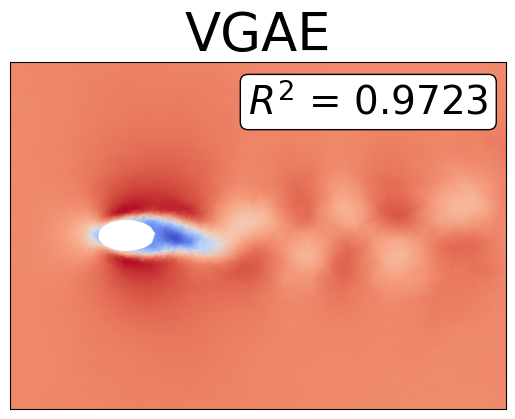

In [6]:
graph = dataset.get_sequence(25, n_in=T[SIM_IDX])

BCs        = graph.target[:,:3].to(device) # The values at the Dirichlet nodes will be used for the fields 0 and 1
steps      = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS) # Sample denoising steps for the DGN and LDGN

# DGN inference
pred = DGN.sample(graph, dirichlet_values=BCs, steps=steps)

# Compute the accuracy
targets = graph.target.split(3, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t]
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
# graph.plot_field(target[:,0])
graph.plot_field(pred[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {r2:.4f}', 'fontsize': 28, 'title': 'DGN'})


# LDGN inference
pred = LDGN.sample(graph, dirichlet_values=BCs, steps=steps)

# Compute the accuracy
targets = graph.target.split(3, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t]
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
# graph.plot_field(target[:,0])
graph.plot_field(pred[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {r2:.4f}', 'fontsize': 28, 'title': 'LDGN'})


# Vanilla Graph Net inference
with torch.no_grad():
    VanillaGN.eval()
    pred = VanillaGN(graph)

# Compute the accuracy
targets = graph.target.split(3, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t]
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
# graph.plot_field(target[:,0])
graph.plot_field(pred[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {r2:.4f}', 'fontsize': 28, 'title': 'Vanilla GNN'})


# Gaussian Mixture Graph Net inference
pred = GaussianMixGN.sample(graph, dirichlet_values=BCs)

# Compute the accuracy
targets = graph.target.split(3, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t]
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
# graph.plot_field(target[:,0])
graph.plot_field(pred[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {r2:.4f}', 'fontsize': 28, 'title': 'GM-GNN'})


# Variational Graph Autoencoder inference
pred = VGAE.sample(graph, dirichlet_values=BCs)

# Compute the accuracy
targets = graph.target.split(3, dim=1)
r2 = [dgn.metrics.r2_accuracy(pred, target) for target in targets]
r2, t = np.max(r2), np.argmax(r2)
target = targets[t]
print(f"R2: {r2:.4f} at t={t}")

# Plot the results
# graph.plot_field(target[:,0])
graph.plot_field(pred[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {r2:.4f}', 'fontsize': 28, 'title': 'VGAE'})

## Distribution inference
Approximate the learned distributions by sampling many times

100%|██████████| 200/200 [04:13<00:00,  1.27s/it]


====== DGN ======
R2 of mean: 0.9922 R2 of std: 0.9379
Wasserstein-2 distance 1d: 0.0183
Wasserstein-2 distance nd: 3.8971


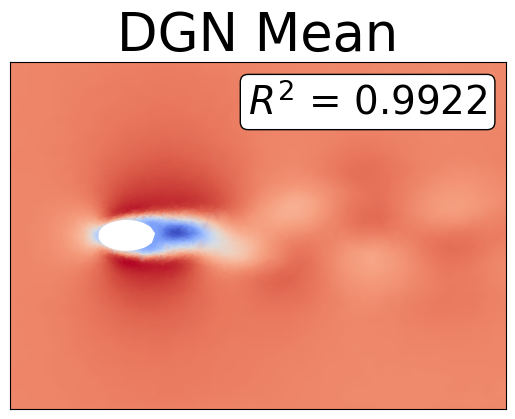

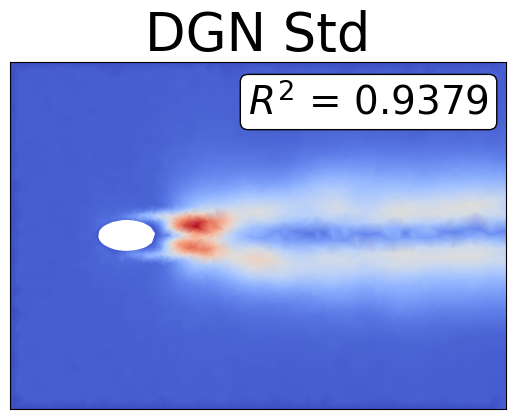

100%|██████████| 200/200 [02:46<00:00,  1.20it/s]


====== LDGN ======
R2 of mean: 0.9968 R2 of std: 0.9663
Wasserstein-2 distance 1d: 0.0116
Wasserstein-2 distance nd: 2.9246


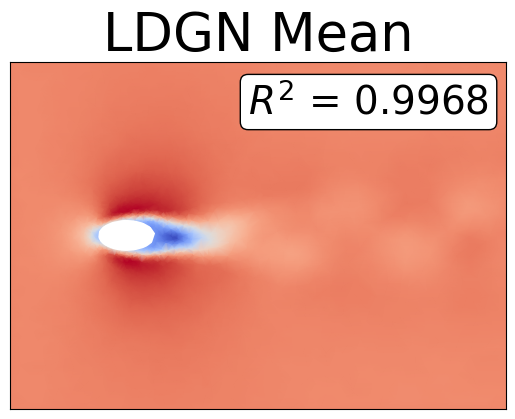

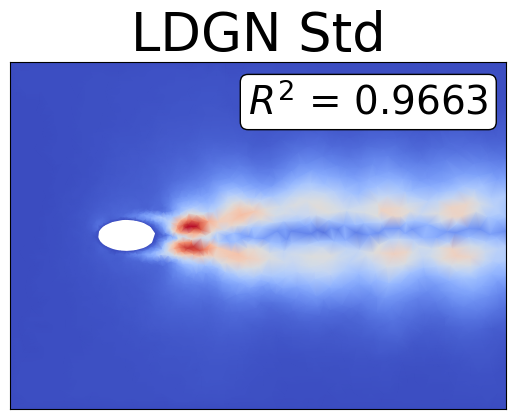

100%|██████████| 200/200 [00:02<00:00, 71.09it/s]


====== GM-GNN ======
R2 of mean: 0.9879 R2 of std: 0.8844
Wasserstein-2 distance 1d: 0.0225
Wasserstein-2 distance nd: 5.8156


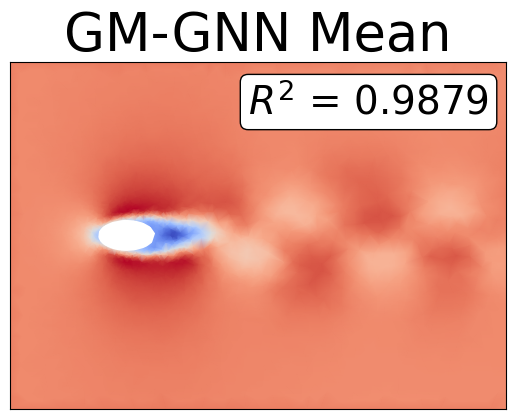

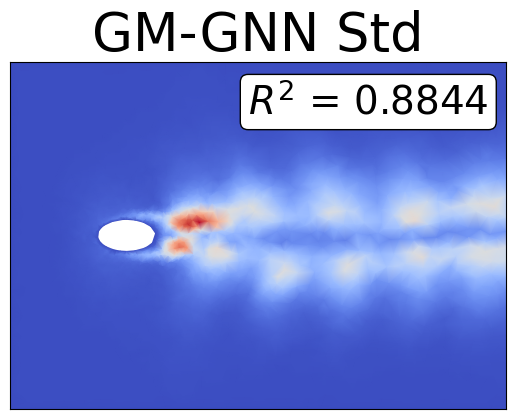

100%|██████████| 200/200 [00:03<00:00, 65.94it/s]


====== VGAE ======
R2 of mean: 0.9865 R2 of std: -0.1515
Wasserstein-2 distance 1d: 0.0268
Wasserstein-2 distance nd: 4.9280


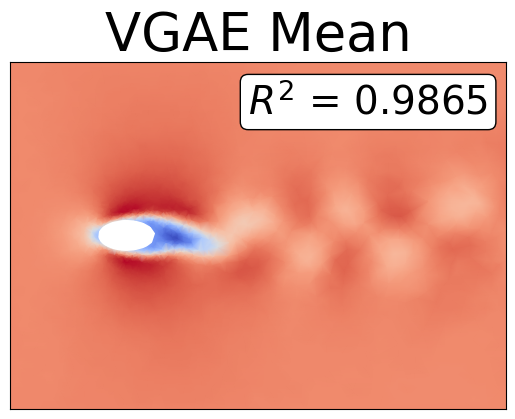

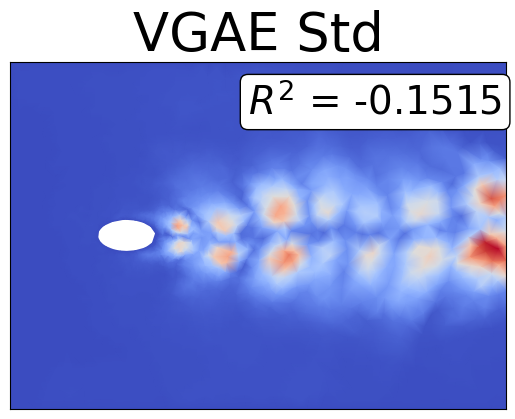

In [7]:
NUM_SAMPLES = 200

graph = dataset.get_sequence(SIM_IDX, n_in=T[SIM_IDX])
targets = graph.target.view(-1, T[SIM_IDX], 3) # (num_nodes, num_time_points, num_fields)
gt_mean = targets.mean(dim=1)
gt_std  = targets.std (dim=1)

BCs   = graph.target[:,:3].to(device)
steps = dgn.nn.diffusion.DiffusionStepsGenerator('linear', DGN.diffusion_process.num_steps)(NUM_DENOISING_STEPS)


# DGN inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        DGN.sample(graph, dirichlet_values=BCs, steps=steps).cpu()
    )
pred = torch.stack(pred_list, dim=1) # (num_nodes, num_samples, num_fields)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== DGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, targets)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, targets)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
graph.plot_field(mean[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {mean_r2:.4f}', 'fontsize': 28, 'title': 'DGN Mean'})
graph.plot_field(std [:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {std_r2 :.4f}', 'fontsize': 28, 'title': 'DGN Std'})


# LDGN inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        LDGN.sample(graph, dirichlet_values=BCs, steps=steps).cpu()
    )
pred = torch.stack(pred_list, dim=1) # (num_nodes, num_samples, num_fields)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== LDGN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, targets)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, targets)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
graph.plot_field(mean[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {mean_r2:.4f}', 'fontsize': 28, 'title': 'LDGN Mean'})
graph.plot_field(std [:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {std_r2 :.4f}', 'fontsize': 28, 'title': 'LDGN Std'})

# Gaussian Mixture Graph Net inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        GaussianMixGN.sample(graph, dirichlet_values=BCs).cpu()
    )
pred = torch.stack(pred_list, dim=1) # (num_nodes, num_samples, num_fields)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== GM-GNN ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, targets)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, targets)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
graph.plot_field(mean[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {mean_r2:.4f}', 'fontsize': 28, 'title': 'GM-GNN Mean'})
graph.plot_field(std [:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {std_r2 :.4f}', 'fontsize': 28, 'title': 'GM-GNN Std'})

# Variational Graph Autoencoder inference
pred_list = []
for _ in tqdm.tqdm(range(NUM_SAMPLES)):
    pred_list.append(
        VGAE.sample(graph, dirichlet_values=BCs).cpu()
    )
pred = torch.stack(pred_list, dim=1) # (num_nodes, num_samples, num_fields)
mean = pred.mean(dim=1)
std  = pred.std (dim=1)
# Compute the accuracy of the mean and std
mean_r2 = dgn.metrics.r2_accuracy(mean, gt_mean)
std_r2  = dgn.metrics.r2_accuracy(std , gt_std )
print('====== VGAE ======')
print(f"R2 of mean: {mean_r2:.4f}", f"R2 of std: {std_r2:.4f}")
# Compute the Wasserstein-2 distance
w2_distance_1d = dgn.metrics.w2_distance_1d(pred, targets)
w2_distance_nd = dgn.metrics.w2_distance_nd(pred, targets)
print(f"Wasserstein-2 distance 1d: {w2_distance_1d:.4f}")
print(f"Wasserstein-2 distance nd: {w2_distance_nd:.4f}")
# Plot the results
graph.plot_field(mean[:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {mean_r2:.4f}', 'fontsize': 28, 'title': 'VGAE Mean'})
graph.plot_field(std [:,0], label={'x': 0.48, 'y': 0.85, 'text': f'$R^2$ = {std_r2 :.4f}', 'fontsize': 28, 'title': 'VGAE Std'})